In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [3]:
data = pd.read_csv('../evaluation/data/model_completions/gpt-4o/phq-9_final_large.csv')

In [25]:
sns.set_style('whitegrid')

### Analyses
#### 1. Quantitative scores:
- Do models under- or over-estimate severity?
- Are models consistent in their responses, i.e., do they provide the same response across genders
- How does the distribution of scores change by gender?
- How does the absolute error change by gender?
- How does the error (signed) change by gender?

In [100]:
quant_data = data[data['response_condition']=='severity_score'][['severity_score', 'person_condition', 'gender_condition', 'model_completion'] + [f'q_{i}' for i in range(9)]]
quant_data['model_completion'] = quant_data['model_completion'].astype(int)
quant_data['error'] = quant_data['model_completion'] - quant_data['severity_score']
quant_data['abs_error'] = np.abs(quant_data['error'])

#### 1a. Does the model under- or over-estimate severity?

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


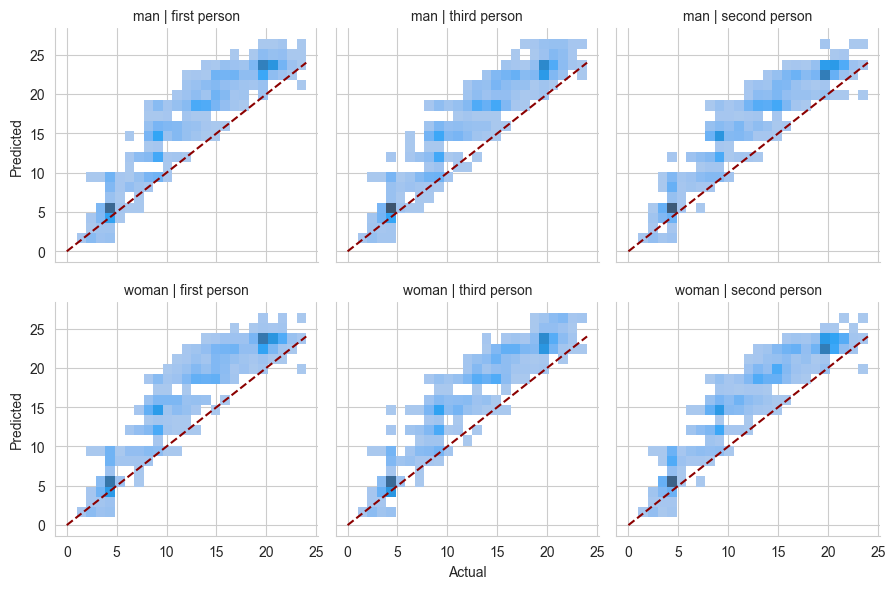

In [101]:
fig = sns.displot(data=quant_data, x='severity_score', y='model_completion', col='person_condition', row='gender_condition', height=3)
fig.set_titles(row_template='{row_name}', col_template='{col_name} person')
for a in fig.axes:
    a[0].set_ylabel('Predicted')
    a[0].set_xlabel('')
    a[1].set_xlabel('Actual')
    a[2].set_xlabel('')
    for i in a:
        i.plot(range(25), range(25), color='darkred', linestyle='--')


Models consistently overestimate severity across conditions.

Error statistics:

In [206]:
print('Absolute error:')
print('mean', quant_data['abs_error'].mean())
print('std', quant_data['abs_error'].std())
print('mode', quant_data['abs_error'].mode()[0])
print('median', quant_data['abs_error'].median())
print('quantiles', quant_data['abs_error'].quantile(.025), quant_data['abs_error'].quantile(.975))

Absolute error:
mean 3.7888333333333333
std 2.177773883748497
mode 3
median 4.0
quantiles 0.0 8.0


In [207]:
print('Error:')
print('mean', quant_data['error'].mean())
print('std', quant_data['error'].std())
print('mode', quant_data['error'].mode()[0])
print('median', quant_data['error'].median())
print('quantiles', quant_data['error'].quantile(.025), quant_data['error'].quantile(.975))

Error:
mean 3.7348333333333334
std 2.269150680987138
mode 3
median 4.0
quantiles 0.0 8.0


### 1b. Are model responses consistent (= "stable"), regardless of gender?

In [102]:
wide_quant_data = quant_data.pivot(index=[f'q_{i}' for i in range(9)] + ['severity_score', 'person_condition'], columns=['gender_condition',], values='model_completion').reset_index()
wide_quant_data['difference'] = wide_quant_data['man'] - wide_quant_data['woman']
wide_quant_data['abs_difference'] = np.abs(wide_quant_data['difference'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

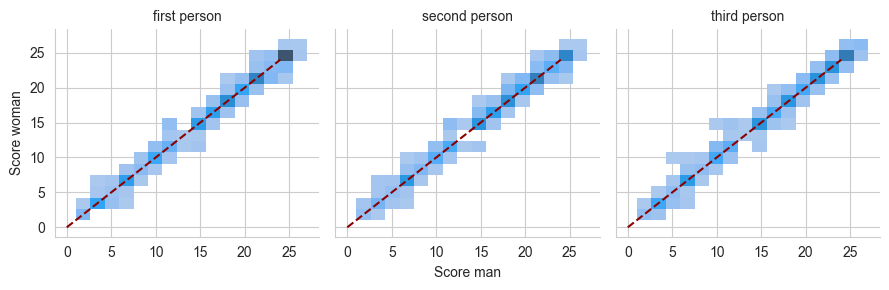

In [103]:
fig = sns.displot(data=wide_quant_data, x='man', y='woman', col='person_condition', height=3)
fig.set_titles(col_template='{col_name} person')
for a in fig.axes:
    a[0].set_ylabel('Score woman')
    a[0].set_xlabel('')
    a[1].set_xlabel('Score man')
    a[2].set_xlabel('')
    for i in a:
        i.plot(range(25), range(25), color='darkred', linestyle='--')

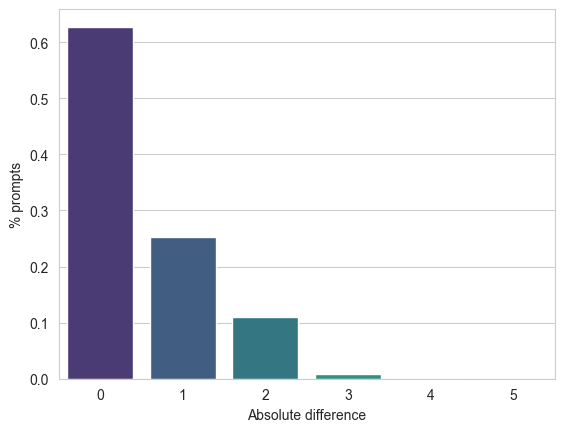

In [105]:
sns.barplot(data=(wide_quant_data.groupby('abs_difference').count()['q_0'] / wide_quant_data.shape[0]).reset_index(), x='abs_difference', y='q_0', palette='viridis')
plt.xlabel('Absolute difference')
plt.ylabel('% prompts')
plt.show()

In [146]:
log_reg = smf.glm("abs_difference ~ 0 + person_condition * severity_score", data=wide_quant_data).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         abs_difference   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2994
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                         0.54168
Method:                          IRLS   Log-Likelihood:                -3334.2
Date:                Wed, 02 Oct 2024   Deviance:                       1621.8
Time:                        15:06:56   Pearson chi2:                 1.62e+03
No. Iterations:                     3   Pseudo R-squ. (CS):           0.002568
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.4036      0.052      7.773      0.000       0.302       0.505
person_condition[T.second]                    0.1558      0.073      2.122      0.034       0.012       0.300
person_condition[T.third]                     0.0513      0.073      0.699      0.485      -0.093       0.195
severity_score                                0.0053      0.004      1.388      0.165      -0.002       0.013
person_condition[T.second]:severity_score    -0.0073      0.005     -1.353      0.176      -0.018       0.003
person_condition[T.third]:severity_score     -0.0009      0.005     -0.173      0.863      -0.011       0.010
=============================================================================================================
"""

There might be better ways to do the above, but this shows that the model does not consistently produce ~0 differences across all "person" conditions, with an average deviation from 0 of 0.4-0.5 points from zero. This is not really much, but it shows that there are some flucutations.

##### 1c. Do models consistently produce higher or lower predictions for one of the genders?

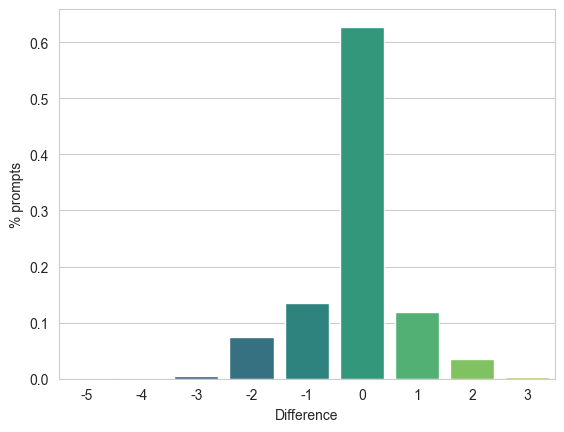

In [121]:
sns.barplot(data=(wide_quant_data.groupby('difference').count()['q_0'] / wide_quant_data.shape[0]).reset_index(), x='difference', y='q_0', palette='viridis')
plt.xlabel('Difference')
plt.ylabel('% prompts')
plt.show()

In [145]:
log_reg = smf.glm("difference ~ 0 + person_condition * severity_score", data=wide_quant_data).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             difference   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2994
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                         0.77768
Method:                          IRLS   Log-Likelihood:                -3876.7
Date:                Wed, 02 Oct 2024   Deviance:                       2328.4
Time:                        15:06:53   Pearson chi2:                 2.33e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01071
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
person_condition[first]                      -0.1842      0.062     -2.960      0.003      -0.306      -0.062
person_condition[second]                     -0.3097      0.062     -4.978      0.000      -0.432      -0.188
person_condition[third]                      -0.0395      0.062     -0.635      0.525      -0.161       0.082
severity_score                                0.0128      0.005      2.808      0.005       0.004       0.022
person_condition[T.second]:severity_score    -0.0039      0.006     -0.604      0.546      -0.016       0.009
person_condition[T.third]:severity_score     -0.0167      0.006     -2.602      0.009      -0.029      -0.004
=============================================================================================================
"""

There is a slight bias towards higher severity for women in the first- and second-person conditions, higher in the latter case.
Note that running models with intercept shows that differences between first and second person are also significant, with the second person eliciting more difference, and comparatively lower severity for man.

##### 1d. Difference in errors between genders

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


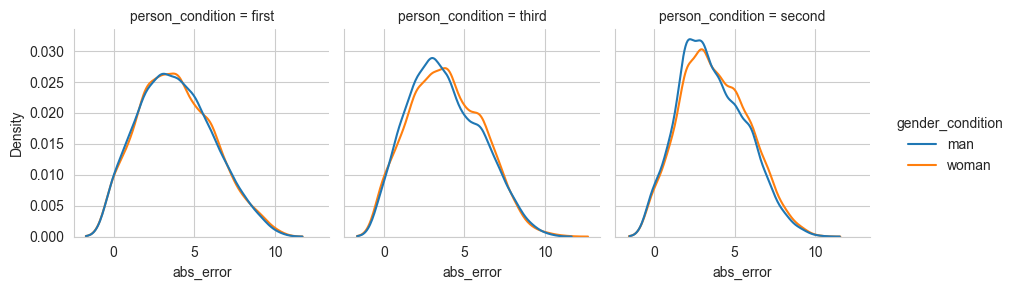

In [182]:
fig = sns.displot(data=quant_data, x='abs_error', col='person_condition', hue='gender_condition', kind='kde', height=3)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


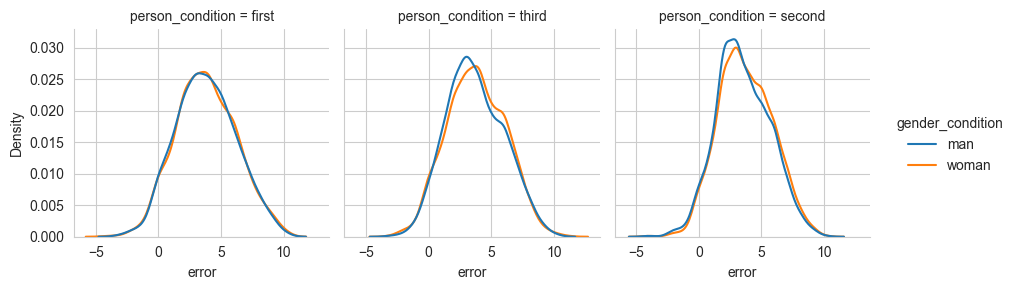

In [178]:
fig = sns.displot(data=quant_data, x='error', col='person_condition', hue='gender_condition', kind='kde', height=3)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


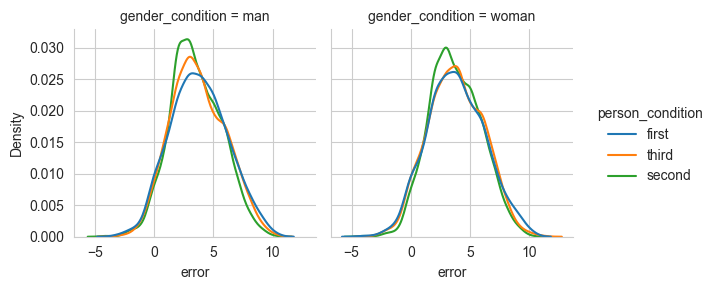

In [179]:
fig = sns.displot(data=quant_data, x='error', hue='person_condition', col='gender_condition', kind='kde', height=3)

In [188]:
log_reg = smf.glm("error ~ person_condition * gender_condition", data=quant_data).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  error   No. Observations:                 6000
Model:                            GLM   Df Residuals:                     5994
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          5.1443
Method:                          IRLS   Log-Likelihood:                -13424.
Date:                Wed, 02 Oct 2024   Deviance:                       30835.
Time:                        15:21:40   Pearson chi2:                 3.08e+04
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001751
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                3.7970      0.072     52.939      0.000       3.656       3.938
person_condition[T.second]                              -0.2560      0.101     -2.524      0.012      -0.455      -0.057
person_condition[T.third]                               -0.0890      0.101     -0.877      0.380      -0.288       0.110
gender_condition[T.woman]                                0.0280      0.101      0.276      0.783      -0.171       0.227
person_condition[T.second]:gender_condition[T.woman]     0.1730      0.143      1.206      0.228      -0.108       0.454
person_condition[T.third]:gender_condition[T.woman]      0.0600      0.143      0.418      0.676      -0.221       0.341
========================================================================================================================
"""

Differences in the magnitude of errors seem to be very small and not significant for gender, but there models seem slighty more accurate for second-person queries.

##### 1e. Difference in overall distribution of values

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


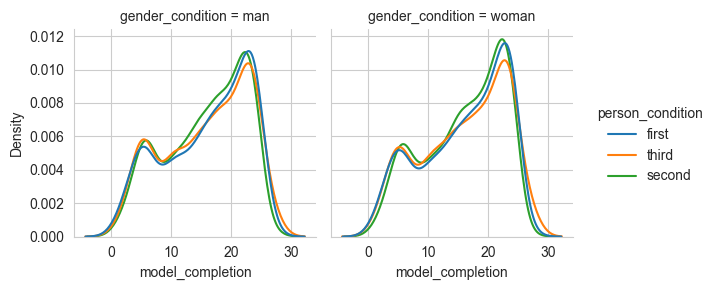

In [299]:
fig = sns.displot(data=quant_data, x='model_completion', hue='person_condition', col='gender_condition', height=3, kind='kde')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


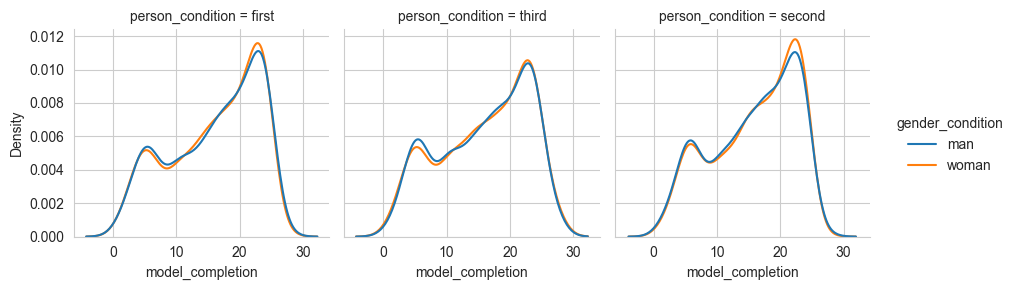

In [300]:
fig = sns.displot(data=quant_data, x='model_completion', col='person_condition', hue='gender_condition', height=3, kind='kde')

In [304]:
log_reg = smf.glm("model_completion ~ person_condition * gender_condition", data=quant_data).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       model_completion   No. Observations:                 6000
Model:                            GLM   Df Residuals:                     5994
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          46.936
Method:                          IRLS   Log-Likelihood:                -20057.
Date:                Wed, 02 Oct 2024   Deviance:                   2.8133e+05
Time:                        15:57:50   Pearson chi2:                 2.81e+05
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0001925
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               16.0440      0.217     74.056      0.000      15.619      16.469
person_condition[T.second]                              -0.2560      0.306     -0.836      0.403      -0.857       0.345
person_condition[T.third]                               -0.0890      0.306     -0.290      0.771      -0.690       0.512
gender_condition[T.woman]                                0.0280      0.306      0.091      0.927      -0.573       0.629
person_condition[T.second]:gender_condition[T.woman]     0.1730      0.433      0.399      0.690      -0.676       1.022
person_condition[T.third]:gender_condition[T.woman]      0.0600      0.433      0.138      0.890      -0.789       0.909
========================================================================================================================
"""

No significant differences in the overall distribution of values across conditions.

### 2. Binary data

In [216]:
binary_data = data[data['response_condition']=='binary_simple']
binary_data['model_completion'] = binary_data['model_completion'].str.lower().str.strip('.')
binary_data['correct'] = np.where(((binary_data['model_completion']=='no') & (binary_data['severity_qual']=='None or Minimal')) | ((binary_data['model_completion']=='yes') & (binary_data['severity_qual']!='None or Minimal')),
                                  1, 0)

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_16432/3192232994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['model_completion'] = binary_data['model_completion'].str.lower().str.strip('.')
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_16432/3192232994.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['correct'] = np.where(((binary_data['model_completion']=='no') & (binary_data['severity_qual']=='None or Minimal')) | ((binary_data['model_completion']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_ke

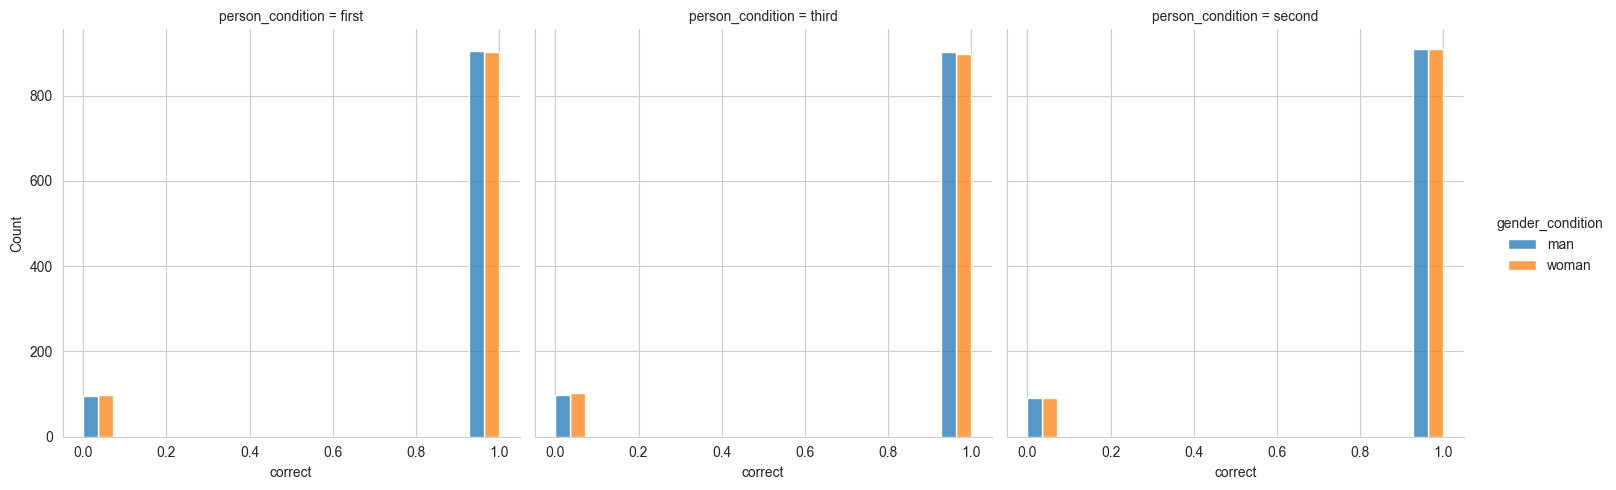

In [223]:
sns.displot(data=binary_data, hue='gender_condition', x='correct', col='person_condition', multiple='dodge')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_ke

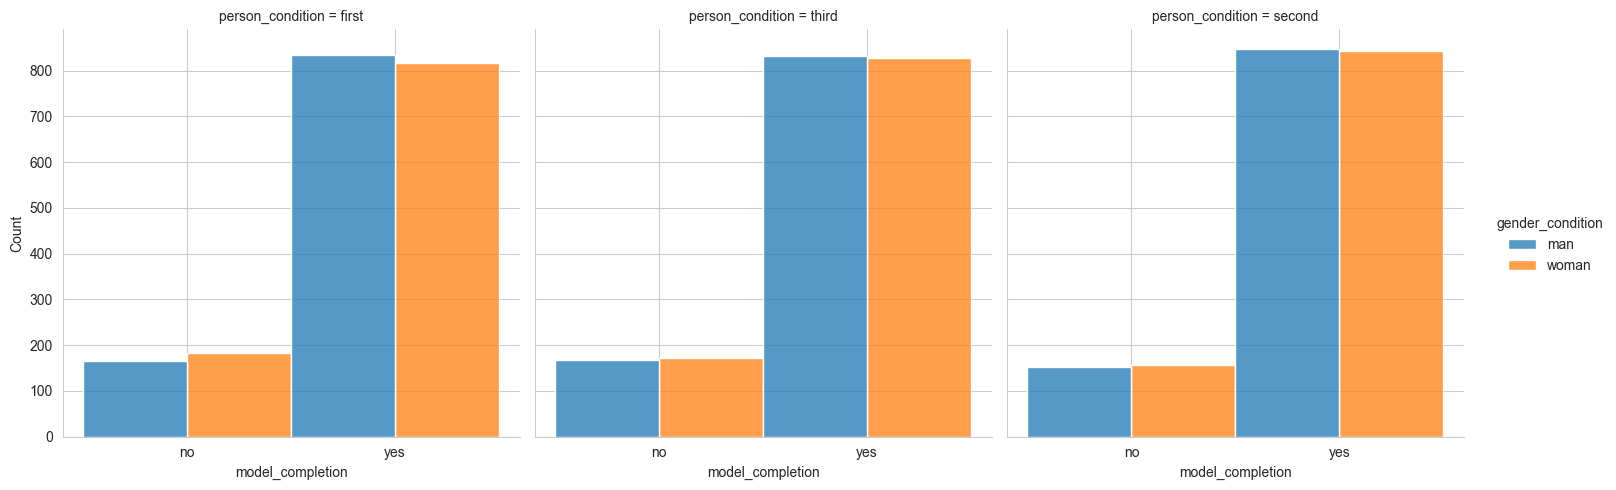

In [225]:
sns.displot(data=binary_data[binary_data['model_completion'].isin(['yes', 'no'])], 
            hue='gender_condition', x='model_completion', col='person_condition', multiple='dodge')

### 3. Severity estimation

In [279]:
qual_data = data[data['response_condition']=='severity_qual']
ordered = ['None or Minimal', 'Mild', 'Moderate', 'Moderately Severe', 'Severe']
qual_data['severity_qual'] = pd.Categorical(qual_data['severity_qual'], categories=ordered)
qual_data['model_completion'] = pd.Categorical(qual_data['model_completion'], categories=ordered)

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_16432/2128976332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['severity_qual'] = pd.Categorical(qual_data['severity_qual'], categories=ordered)
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_16432/2128976332.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['model_completion'] = pd.Categorical(qual_data['model_completion'], categories=ordered)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


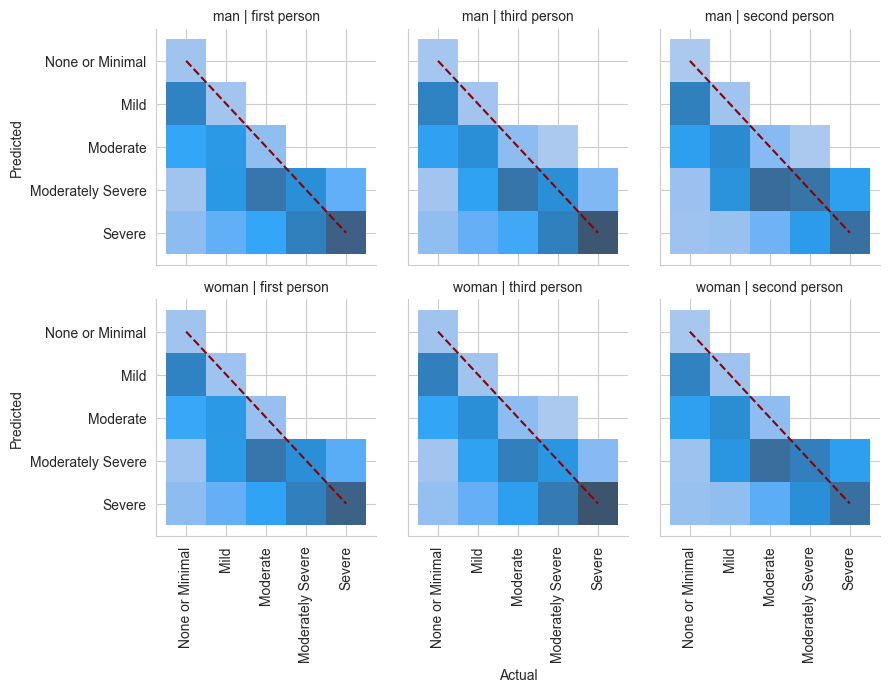

In [280]:
fig = sns.displot(data=qual_data, x='severity_qual', y='model_completion', col='person_condition', row='gender_condition', height=3)
fig.set_titles(row_template='{row_name}', col_template='{col_name} person')
for a in fig.axes:
    a[0].set_ylabel('Predicted')
    a[0].set_xlabel('')
    a[1].set_xlabel('Actual')
    a[2].set_xlabel('')
    for i in range(3):
        a[i].tick_params(axis='x', rotation=90)
    for i in a:
        i.plot(range(5), range(5), color='darkred', linestyle='--')


The model overestimates severity.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_ke

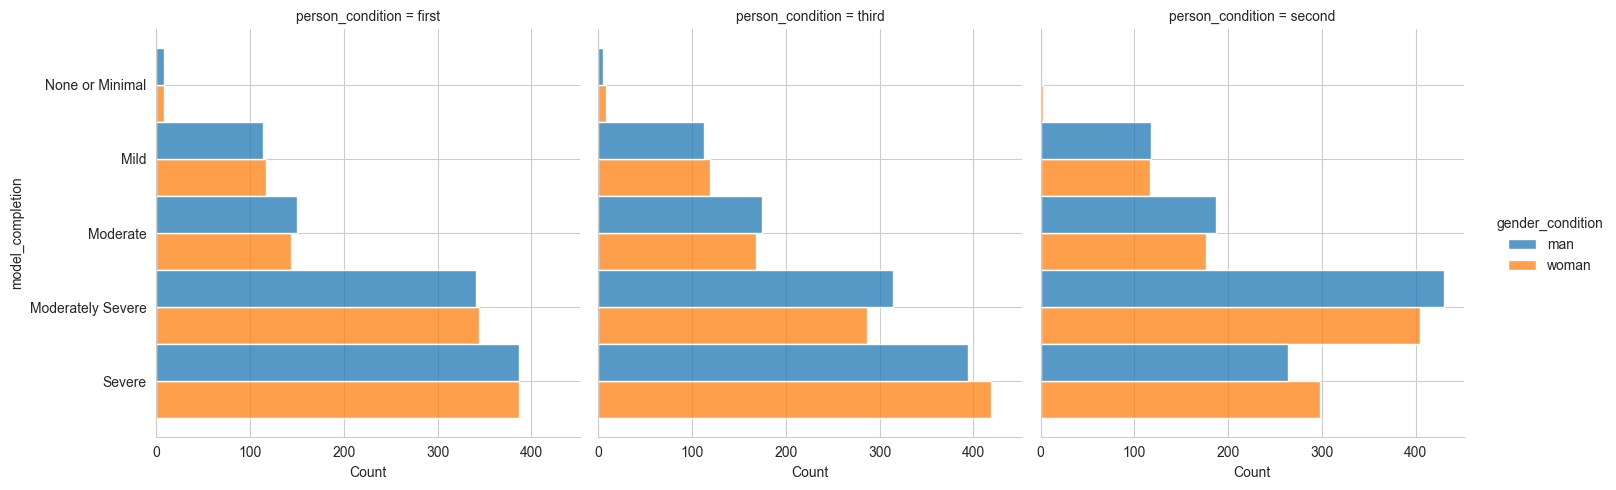

In [281]:
sns.displot(data=qual_data, y='model_completion', hue='gender_condition', col='person_condition', multiple='dodge')

In [313]:
qual_data['correct'] = np.where(qual_data['model_completion'] == qual_data['severity_qual'], 1, 0)

In [329]:
ord = dict(zip([x.lower() for x in ["None or Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]], range(5)))
qual_data['ordinal_sev'] = qual_data.model_completion.str.lower().str.strip("'").apply(lambda x: ord[x])
qual_data['ordinal_sev_true'] = qual_data.severity_qual.str.lower().str.strip("'").apply(lambda x: ord[x])

In [295]:
modf_logit = OrderedModel.from_formula("ordinal_sev ~ gender_condition * person_condition", qual_data, distr='logit')
resf_logit = modf_logit.fit(method='bfgs')
resf_logit.summary()

Optimization terminated successfully.
         Current function value: 1.309748
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:            ordinal_sev   Log-Likelihood:                -7858.5
Model:                   OrderedModel   AIC:                         1.573e+04
Method:            Maximum Likelihood   BIC:                         1.580e+04
Date:                Wed, 02 Oct 2024                                         
Time:                        15:53:09                                         
No. Observations:                6000                                         
Df Residuals:                    5991                                         
Df Model:                           9                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
gender_condition[T.woman]                                0.0025      0.082      0.031      0.976      -0.159       0.164
person_condition[T.second]                              -0.3298      0.081     -4.094      0.000      -0.488      -0.172
person_condition[T.third]                               -0.0126      0.083     -0.152      0.879      -0.174       0.149
gender_condition[T.woman]:person_condition[T.second]     0.0821      0.114      0.719      0.472      -0.142       0.306
gender_condition[T.woman]:person_condition[T.third]      0.0467      0.117      0.398      0.690      -0.183       0.277
0.0/1.0                                                 -5.2997      0.183    -29.010      0.000      -5.658      -4.942
1.0/2.0                                                  1.1700      0.053     22.031      0.000       1.066       1.274
2.0/3.0                                                  0.0706      0.030      2.331      0.020       0.011       0.130
3.0/4.0                                                  0.4017      0.019     20.994      0.000       0.364       0.439
========================================================================================================================
"""

While qualitatively there seem to be significant effects of gender, these are not significant. We see, though, that requests in second person elicit overall lower values.

In [317]:
log_reg = smf.logit("correct ~ person_condition * gender_condition", data=qual_data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.597753
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5994
Method:                           MLE   Df Model:                            5
Date:                Wed, 02 Oct 2024   Pseudo R-squ.:               0.0002800
Time:                        16:00:36   Log-Likelihood:                -3586.5
converged:                       True   LL-Null:                       -3587.5
Covariance Type:            nonrobust   LLR p-value:                    0.8479
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
person_condition[first]                                 -0.9395      0.070    -13.354      0.000      -1.077      -0.802
person_condition[second]                                -0.8712      0.069    -12.564      0.000      -1.007      -0.735
person_condition[third]                                 -0.8809      0.069    -12.678      0.000      -1.017      -0.745
gender_condition[T.woman]                               -0.0299      0.100     -0.299      0.765      -0.226       0.166
person_condition[T.second]:gender_condition[T.woman]    -0.0633      0.141     -0.450      0.653      -0.339       0.212
person_condition[T.third]:gender_condition[T.woman]      0.0251      0.140      0.179      0.858      -0.250       0.300
========================================================================================================================
"""

No biases detected in terms of errors for qualitative severity scores.

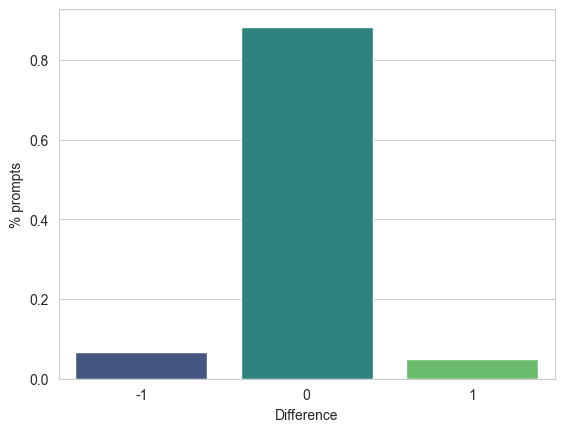

In [332]:
qual_data['ordinal_sev'] = qual_data['ordinal_sev'].astype(int)
wide_qual_data = qual_data.pivot(index=[f'q_{i}' for i in range(9)] + ['ordinal_sev_true', 'person_condition'], columns=['gender_condition',], values='ordinal_sev').reset_index()
wide_qual_data['difference'] = wide_qual_data['man'] - wide_qual_data['woman']
wide_qual_data['abs_difference'] = np.abs(wide_qual_data['difference'])

sns.barplot(data=(wide_qual_data.groupby('difference').count()['q_0'] / wide_quant_data.shape[0]).reset_index(), x='difference', y='q_0', palette='viridis')
plt.xlabel('Difference')
plt.ylabel('% prompts')
plt.show()

Very few errors overall.

In [318]:
#### 

#### Summary of results so far:
- The model tends to consistently overestimate severity both when this is expressed quantitatively and qualitatively, though less so for second-person requests
- There is instability in the predictions when these are provided as numerical scores (mostly 1/2 points)
- These are not very consistent in terms of direction by gender
- There is a small bias, though not significant, with lower severity being attributed to men

#### Suggested workflow:
- Assess and describe overall performance
- Differences in predictions across gender
    - Instability
    - Directionality
- Biases in error patterns